# Plant Disease Classification using CNN

**Import neccessary packages**

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [22]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantdisease'
width=256
height=256
depth=3

**Function to convert images to array**

In [23]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        blur_image=cv2.blur(image,(3,3))
        clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(5,5))

        lab = cv2.cvtColor(blur_image, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
        l, a, b = cv2.split(lab)  # split on 3 different channels

        l2 = clahe.apply(l)  # apply CLAHE to the L-channel

        lab = cv2.merge((l2,a,b))  # merge channels
        img2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
       
        if image is not None :
            image = cv2.resize(img2, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

**Fetch images from directory**

In [24]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


**Get Size of Processed Image**

In [25]:
image_size = len(image_list)
print(image_size)

2952


**Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer**

In [26]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [27]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [28]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [29]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [30]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

**Model Building**

In [31]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

**Model Summary*

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 85, 85, 64)       

In [33]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [34]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
73/73 [==============================] - 287s 4s/step - loss: 2.5293 - accuracy: 0.3200 - val_loss: 22.6910 - val_accuracy: 0.0778
Epoch 2/20
73/73 [==============================] - 286s 4s/step - loss: 1.4391 - accuracy: 0.5600 - val_loss: 13.9472 - val_accuracy: 0.0694
Epoch 3/20
73/73 [==============================] - 285s 4s/step - loss: 1.2231 - accuracy: 0.6257 - val_loss: 10.9003 - val_accuracy: 0.0728
Epoch 4/20
73/73 [==============================] - 286s 4s/step - loss: 1.1619 - accuracy: 0.6400 - val_loss: 18.8264 - val_accuracy: 0.0575
Epoch 5/20
73/73 [==============================] - 286s 4s/step - loss: 1.1371 - accuracy: 0.6486 - val_loss: 9.3529 - val_accuracy: 0.2420
Epoch 6/20
73/73 [==============================] - 286s 4s/step - loss: 1.1472 - accuracy: 0.6583 - val_loss: 5.6745 - val_accuracy: 0.2098
Epoch 7/20
73/73 [==============================] - 285s 4s/step - loss: 0.7873 - accuracy: 0.7584 - val_loss: 5.0365 - val_accuracy: 0.3046
Epoch 8/2

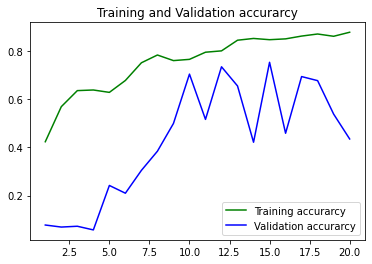

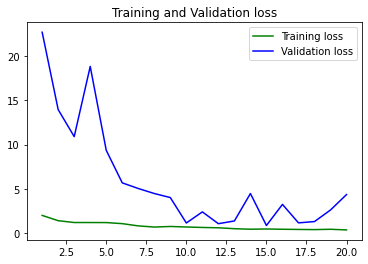

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [36]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 16s 843ms/step - loss: 4.3545 - accuracy: 0.4349
Test Accuracy: 43.48561763763428


In [37]:
predictions = model.predict(x_test)

In [38]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)


[[ 5 18  0  0  0  0  0  0  0  6  5  0  2  0  9]
 [ 0 32  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 11  7  3  0  0  0  0  2  2  0  0  0 11]
 [ 0  8  0  0 25  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  1  5  0  0  0  0  1  1  5  0 27]
 [ 0  2  4  0  1  0  2  0  0  0  2  0  1  0 23]
 [ 1  3  8  0  0  1  0 10  0  0  3  0  0  0 25]
 [ 0  3  0  0  0  0  0  0 12  1  0  0  4  2 26]
 [ 0  4  1  0  0  1  1  0  1 22  0  0  0  1  6]
 [ 0  6  0  0  0  0  0  0  0  0 11  0  0  0 30]
 [ 0  1  0  0  0  0  0  0  0  0  0  1  0  0 36]
 [ 0  1  0  0  0  0  0  0  0  0  4  0 26  0  2]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 20 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 41]]


In [39]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)


[[ 5 18  0  0  0  0  0  0  0  6  5  0  2  0  9]
 [ 0 32  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 38  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0  0 11  7  3  0  0  0  0  2  2  0  0  0 11]
 [ 0  8  0  0 25  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  2  0  1  5  0  0  0  0  1  1  5  0 27]
 [ 0  2  4  0  1  0  2  0  0  0  2  0  1  0 23]
 [ 1  3  8  0  0  1  0 10  0  0  3  0  0  0 25]
 [ 0  3  0  0  0  0  0  0 12  1  0  0  4  2 26]
 [ 0  4  1  0  0  1  1  0  1 22  0  0  0  1  6]
 [ 0  6  0  0  0  0  0  0  0  0 11  0  0  0 30]
 [ 0  1  0  0  0  0  0  0  0  0  0  1  0  0 36]
 [ 0  1  0  0  0  0  0  0  0  0  4  0 26  0  2]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 20 11]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 41]]


**Training**

with blur

In [14]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
73/73 [==============================] - 325s 4s/step - loss: 2.6708 - accuracy: 0.3390 - val_loss: 6.8311 - val_accuracy: 0.0728
Epoch 2/20
73/73 [==============================] - 322s 4s/step - loss: 1.5376 - accuracy: 0.5515 - val_loss: 12.3932 - val_accuracy: 0.0694
Epoch 3/20
73/73 [==============================] - 321s 4s/step - loss: 1.2910 - accuracy: 0.5999 - val_loss: 12.6959 - val_accuracy: 0.1489
Epoch 4/20
73/73 [==============================] - 320s 4s/step - loss: 1.2253 - accuracy: 0.6302 - val_loss: 11.1318 - val_accuracy: 0.1117
Epoch 5/20
73/73 [==============================] - 320s 4s/step - loss: 1.0140 - accuracy: 0.6809 - val_loss: 11.9373 - val_accuracy: 0.1049
Epoch 6/20
73/73 [==============================] - 321s 4s/step - loss: 1.0013 - accuracy: 0.6872 - val_loss: 11.6252 - val_accuracy: 0.1472
Epoch 7/20
73/73 [==============================] - 320s 4s/step - loss: 1.0519 - accuracy: 0.6724 - val_loss: 5.1004 - val_accuracy: 0.3130
Epoch 8/

**Plot the train and val curve**

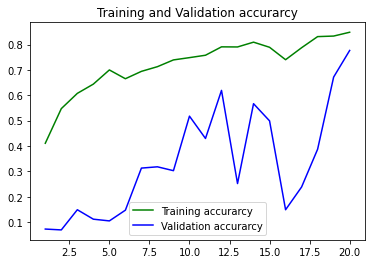

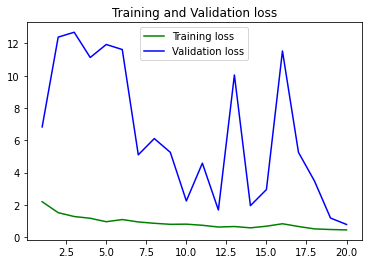

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'b', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

**Model Accuracy**

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 18s 969ms/step - loss: 0.7839 - accuracy: 0.7766
Test Accuracy: 77.66497731208801


In [18]:
predictions = model.predict(x_test)

In [29]:

labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

In [31]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)



[[21 11  0  2  1  0  0  0  0  3  2  1  2  1  1]
 [ 0 32  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 28  2  1  1  0  0  0  0  1  0  0  1]
 [ 0  0  0  0 33  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0 39  3  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  1 27  0  1  0  0  0  0  0  2]
 [ 0  0  8  2  0  1  8 28  0  0  1  0  0  0  3]
 [ 0  1  0  0  0  2  1  0 34  0  2  1  2  0  5]
 [ 0  2  3  0  0  1  2  2  1 20  1  0  1  1  3]
 [ 1  0  0  0  0  0  1  0  0  0 37  0  1  1  6]
 [ 0  0  0  0  1  1  1  0  0  0  5 19  0  0 11]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 31  0  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 30  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 41]]


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.47      0.63        45
           1       0.64      0.97      0.77        33
           2       0.74      1.00      0.85        39
           3       0.88      0.78      0.82        36
           4       0.87      1.00      0.93        33
           5       0.85      0.91      0.88        43
           6       0.59      0.77      0.67        35
           7       0.93      0.55      0.69        51
           8       0.94      0.71      0.81        48
           9       0.87      0.54      0.67        37
          10       0.77      0.79      0.78        47
          11       0.86      0.50      0.63        38
          12       0.84      0.94      0.89        33
          13       0.91      0.94      0.92        32
          14       0.55      1.00      0.71        41

    accuracy                           0.78       591
   macro avg       0.81      0.79      0.78       591
weighted avg       0.82   

without blur

In [48]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
73/73 [==============================] - 325s 4s/step - loss: 2.5037 - accuracy: 0.3526 - val_loss: 8.8227 - val_accuracy: 0.0728
Epoch 2/20
73/73 [==============================] - 322s 4s/step - loss: 1.6484 - accuracy: 0.5161 - val_loss: 23.8639 - val_accuracy: 0.0728
Epoch 3/20
73/73 [==============================] - 321s 4s/step - loss: 1.0615 - accuracy: 0.6543 - val_loss: 14.9884 - val_accuracy: 0.0948
Epoch 4/20
73/73 [==============================] - 323s 4s/step - loss: 0.9905 - accuracy: 0.6696 - val_loss: 20.4222 - val_accuracy: 0.0711
Epoch 5/20
73/73 [==============================] - 320s 4s/step - loss: 0.8930 - accuracy: 0.7124 - val_loss: 11.4888 - val_accuracy: 0.1286
Epoch 6/20
73/73 [==============================] - 320s 4s/step - loss: 0.8476 - accuracy: 0.7223 - val_loss: 8.7984 - val_accuracy: 0.1726
Epoch 7/20
73/73 [==============================] - 320s 4s/step - loss: 0.7541 - accuracy: 0.7549 - val_loss: 6.7453 - val_accuracy: 0.2504
Epoch 8/2

In [49]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 19s 986ms/step - loss: 2.1957 - accuracy: 0.6413
Test Accuracy: 64.12859559059143


In [50]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print(cm)


[[21 11  0  2  1  0  0  0  0  3  2  1  2  1  1]
 [ 0 32  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 39  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2 28  2  1  1  0  0  0  0  1  0  0  1]
 [ 0  0  0  0 33  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0 39  3  0  0  0  0  0  0  0  0]
 [ 0  3  1  0  0  1 27  0  1  0  0  0  0  0  2]
 [ 0  0  8  2  0  1  8 28  0  0  1  0  0  0  3]
 [ 0  1  0  0  0  2  1  0 34  0  2  1  2  0  5]
 [ 0  2  3  0  0  1  2  2  1 20  1  0  1  1  3]
 [ 1  0  0  0  0  0  1  0  0  0 37  0  1  1  6]
 [ 0  0  0  0  1  1  1  0  0  0  5 19  0  0 11]
 [ 0  0  0  0  0  0  1  0  0  0  0  0 31  0  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0 30  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 41]]


In [51]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.47      0.63        45
           1       0.64      0.97      0.77        33
           2       0.74      1.00      0.85        39
           3       0.88      0.78      0.82        36
           4       0.87      1.00      0.93        33
           5       0.85      0.91      0.88        43
           6       0.59      0.77      0.67        35
           7       0.93      0.55      0.69        51
           8       0.94      0.71      0.81        48
           9       0.87      0.54      0.67        37
          10       0.77      0.79      0.78        47
          11       0.86      0.50      0.63        38
          12       0.84      0.94      0.89        33
          13       0.91      0.94      0.92        32
          14       0.55      1.00      0.71        41

    accuracy                           0.78       591
   macro avg       0.81      0.79      0.78       591
weighted avg       0.82   